In [83]:
#Pre-Processing
import os
import re
import torch
import random
import itertools

#Model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np

# For visualising metrics
from visdom import Visdom

# For visualising gradients plot
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import copy
import math
import time

from sklearn.metrics import f1_score

In [47]:
# device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
device=torch.device("cpu")
print("The device found: "+str(device))

The device found: cpu


In [48]:
class VisdomLinePlotter(object):
    """Plots to Visdom"""
    
    def __init__(self, env_name='main'):
        self.viz = Visdom()
        self.env = env_name
        self.plots = {}
    def plot(self, var_name, split_name, title_name, x, y):
        if var_name not in self.plots:
            self.plots[var_name] = self.viz.line(X=np.array([x,x]), Y=np.array([y,y]), env=self.env, opts=dict(
                legend=[split_name],
                title=title_name,
                xlabel='Epochs',
                ylabel=var_name
            ))
        else:
            self.viz.line(X=np.array([x]), Y=np.array([y]), env=self.env, win=self.plots[var_name], name=split_name, update = 'append')

In [49]:
def plot_grad_flow(named_parameters):
    """
        Plotting gradient flow across various layers
        Thanks to: https://discuss.pytorch.org/t/check-gradient-flow-in-network/15063/2
    """   
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            ave_grads.append(p.grad.abs().mean())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

# Preprocessing

In [50]:
path='C:\\Users\\deepa\\Conversational Agents\\Datasets'
dataset='cornell movie-dialogs corpus'

data_folder=os.path.join(path,dataset)

print("The final data corpus folder: "+str(data_folder))

The final data corpus folder: C:\Users\deepa\Conversational Agents\Datasets\cornell movie-dialogs corpus


In [51]:
def get_lines_conversations():
    """
    Loads movie lines and conversations from the dataset.
    
    data_folder: Destination where conversations and lines are stored.
    
    movie_lines: Consist of movie lines as given by the dataset.
    movie_conversations: Consist of movie conversations as given by the dataset.
    
    """
    f=open(os.path.join(data_folder,'movie_lines.txt'),'r')
    movie_lines=f.read().splitlines()
    f.close()
    
    f=open(os.path.join(data_folder,'movie_conversations.txt'),'r')
    movie_conversations=f.read().splitlines()
    f.close()
    
    return movie_lines,movie_conversations


In [52]:
t1=time.time()
print("Extracting movie lines and movie conversations...")
movie_lines,movie_conversations=get_lines_conversations()

print("Number of distinct lines: "+str(len(movie_lines)))
print("Number of conversations: "+str(len(movie_conversations)))
print("Average Number of lines per conversations: "+str(len(movie_lines)/len(movie_conversations)))

print(movie_lines[0])
print(movie_conversations[0])

print("Extracting took place in: "+str(time.time()-t1))

Extracting movie lines and movie conversations...
Number of distinct lines: 304713
Number of conversations: 83097
Average Number of lines per conversations: 3.6669554857576085
L1045 +++$+++ u0 +++$+++ m0 +++$+++ BIANCA +++$+++ They do not!
u0 +++$+++ u2 +++$+++ m0 +++$+++ ['L194', 'L195', 'L196', 'L197']
Extracting took place in: 0.6210422515869141


In [53]:
def loadLines(movie_lines,fields):
    lines={}
    for line in movie_lines:
        values=line.split(" +++$+++ ")
        
        lineVals={}
        
#         print("values"+str(len(values)))
#         print("fields"+str(len(fields)))
              
        for i,field in enumerate(fields):
            lineVals[field]=values[i]
        
        lines[lineVals['lineID']]=lineVals
    
    return lines

def loadConversations(movie_conversations,lines,fields):
    conversations=[]
    
    for convo in movie_conversations:
        values=convo.split(" +++$+++ ")
        conVals={}
       
        for i,field in enumerate(fields):
            conVals[field]=values[i]
        
        lineIDs=eval(conVals["utteranceIDs"])
        
        conVals["lines"]=[]
        
        for lineID in lineIDs:
            conVals["lines"].append(lines[lineID])
        conversations.append(conVals)
        
    return conversations

def sentencePairs(conversations):
    qr_pairs=[]
    
    for conversation in conversations:
        for i in range(len(conversation["lines"])-1):
            query=conversation["lines"][i]["text"].strip()
            response=conversation["lines"][i+1]["text"].strip()
            
            if query and response:
                qr_pairs.append([query,response])
        
    return qr_pairs

In [54]:
t1=time.time()
print("Separating meaningfull information for our model...")

lines={}
conversations=[]
qr_pairs=[]

movie_lines_fields=["lineID","characterID","movieID","character","text"]
movie_convo_fields=["charcaterID","character2ID","movieID","utteranceIDs"]

lines=loadLines(movie_lines,movie_lines_fields)
conversations=loadConversations(movie_conversations,lines,movie_convo_fields)
qr_pairs=sentencePairs(conversations)

print("The number of query-response pairs are: "+str(len(qr_pairs)))
print("Separation took place in: "+str(time.time()-t1))


Separating meaningfull information for our model...
The number of query-response pairs are: 221282
Separation took place in: 3.9398603439331055


In [55]:
PAD_Token=0
START_Token=1
END_Token=2

class Vocabulary:
    def __init__(self):
        self.trimmed=False
        self.word2count={}
        self.index2word={PAD_Token:"PAD",START_Token:"SOS",END_Token:"EOS"}
        self.word2index={"PAD":PAD_Token,"SOS":START_Token,"EOS":END_Token}
        self.num_words=3
        
    def addSentence(self,sentence):
        for word in sentence.split(" "):
            self.addWord(word)
    def addWord(self,word):
        if word not in self.word2index:
            self.word2index[word]=self.num_words
            self.index2word[self.num_words]=word
            self.word2count[word]=1
            self.num_words=self.num_words+1
        else:
            self.word2count[word]+=1
            
    def trim(self,min_count):
        
        if self.trimmed:
            return
        self.trimmed=True
        
        keep_words=[]
        
        for word,freq in self.word2count.items():
            if freq>=min_count:
                keep_words.append(word)
        
        self.word2count={}
        self.index2word={PAD_Token:"PAD",START_Token:"SOS",END_Token:"EOS"}
        self.word2index={"PAD":PAD_Token,"SOS":START_Token,"EOS":END_Token}
        self.num_words=3
        
        for word in keep_words:
            self.addWord(word)

In [56]:
Max_Length=10

def normalizeString(s):
    s=s.lower().strip()
    s=re.sub(r"([.!?])", r" \1", s)
    s=re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    s=re.sub(r"\s+", r" ", s).strip()
    return s

def readVocs(qr_pairs):
    
    for qr_pair in qr_pairs:
        qr_pair[0]=normalizeString(qr_pair[0])
        qr_pair[1]=normalizeString(qr_pair[1])
    
    voc=Vocabulary()
    return voc,qr_pairs

def filterPair(pair):
    return len(pair[0].split(" "))<Max_Length and len(pair[1].split(" "))<Max_Length

def filterPairs(qr_pairs):
    return [pair for pair in qr_pairs if filterPair(pair)]

def prepareDataset(qr_pairs):
    voc, qr_pairs=readVocs(qr_pairs)
    qr_pairs=filterPairs(qr_pairs)
       
    for pair in qr_pairs:
        voc.addSentence(pair[0])
        voc.addSentence(pair[1])
#     print("Number"+str(voc.num_words))
    return voc,qr_pairs

t1=time.time()
print("Preparing dataset and corresponding vocabulary...")
voc, pairs=prepareDataset(qr_pairs)
print("Preparation took place in: "+str(time.time()-t1))

Preparing dataset and corresponding vocabulary...
Preparation took place in: 8.129056930541992


In [57]:
Min_Count=3

def trimRareWords(voc,qr_pairs):
    
    voc.trim(Min_Count)
    keep_pairs=[]
    
    for pair in qr_pairs:
        input_sentence=pair[0]
        output_sentence=pair[1]
        
        keep_input=True
        keep_output=True
        
        for word in input_sentence.split(" "):
            if word not in voc.word2index:
                keep_input=False
                break
        
        for word in output_sentence.split(" "):
            if word not in voc.word2index:
                keep_output=False
                break
                
        if keep_input and keep_output:
            keep_pairs.append(pair)
            
    return keep_pairs

t1=time.time()
print("Trimming rare words from vocabulary and dataset..")

pairs=trimRareWords(voc,pairs)

print("Trimming took place in: "+str(time.time()-t1))


Trimming rare words from vocabulary and dataset..
Trimming took place in: 0.15261006355285645


In [58]:
def indexesFromSentence(voc,sentence):
    tokenised_sentence=[]
    tokenised_sentence.append(START_Token)
    
    for word in sentence.split(" "):
        tokenised_sentence.append(voc.word2index[word])
        
    tokenised_sentence.append(END_Token)
    
    assert len(tokenised_sentence)<=Max_Length+2
    for _ in range(Max_Length+2-len(tokenised_sentence)):
        tokenised_sentence.append(PAD_Token)
        
    return tokenised_sentence

def binaryMatrix(l,value=PAD_Token):
    m=[]
    for i,seq in enumerate(l):
        m.append([])
        for token in seq:
            if token==value:
                m[i].append(0)
            else:
                m[i].append(1)
        
    return m

def inputVar(voc,l):
    
    indexes_batch=[indexesFromSentence(voc,sentence) for sentence in l]
    input_lengths=torch.tensor([len(index) for index in indexes_batch])
    padVar=torch.LongTensor(indexes_batch)
    return input_lengths,padVar

def outputVar(voc,l):
    indexes_batch=[indexesFromSentence(voc,sentence) for sentence in l]
    max_target_len=torch.tensor([len(index) for index in indexes_batch])
    mask=binaryMatrix(indexes_batch)
    mask=torch.ByteTensor(mask)
    padVar=torch.LongTensor(indexes_batch)
    return max_target_len, mask, padVar

def batch2TrainData(voc,pair_batch):
    #sort function see 
    input_batch=[]
    output_batch=[]

    for pair in pair_batch:
        input_batch.append(pair[0])
        output_batch.append(pair[1])
                                  
    
    input_lengths,tokenised_input=inputVar(voc,input_batch)
    max_out_length,mask,tokenised_output=outputVar(voc,output_batch)
    return input_lengths,tokenised_input,max_out_length,mask,tokenised_output



In [59]:
print("Number of query-response pairs after all the preprocessing: "+str(len(pairs)))

#Sample batch
batch=[random.choice(pairs) for _ in range(5)]
input_lengths,tokenised_input,max_out_length,mask,tokenised_output=batch2TrainData(voc,batch)

print("Input length: "+str(input_lengths)+" Size: "+str(input_lengths.shape))
print("-"*80)
print("Tokenised Input: "+str(tokenised_input)+" Size: "+str(tokenised_input.shape))
print("-"*80)
print("Max out length: "+str(max_out_length)+" Size: "+str(max_out_length.shape))
print("-"*80)
print("Mask: "+str(mask)+" Size: "+str(mask.shape))
print("-"*80)
print("Tokenised Output: "+str(tokenised_output)+" Size: "+str(tokenised_output.shape))
print("-"*80)

Number of query-response pairs after all the preprocessing: 53113
Input length: tensor([12, 12, 12, 12, 12]) Size: torch.Size([5])
--------------------------------------------------------------------------------
Tokenised Input: tensor([[   1,  287,   25,  132,   47,   36,    4,    2,    0,    0,    0,    0],
        [   1,   34,    4,    2,    0,    0,    0,    0,    0,    0,    0,    0],
        [   1,  266,  691,  960,  704,    4,   53,  199,  584,    4,    2,    0],
        [   1,   25,   74,    7,    8,   53,  774,  179,    4,    2,    0,    0],
        [   1,   36,   37,   67,   50,  101, 1416,    4,    2,    0,    0,    0]]) Size: torch.Size([5, 12])
--------------------------------------------------------------------------------
Max out length: tensor([12, 12, 12, 12, 12]) Size: torch.Size([5])
--------------------------------------------------------------------------------
Mask: tensor([[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       

# Model 1


In [60]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many 
    other models.
    """
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask,
                            tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [61]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

In [62]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [63]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

In [64]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

In [65]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [66]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [67]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."
    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [68]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)
 
    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [69]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [70]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [71]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

In [72]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))

In [73]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

In [74]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

In [75]:
def make_model(src_vocab, tgt_vocab, N=6, 
               d_model=512, d_ff=2048, h=8, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), 
                             c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab))
    
    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform(p)
    return model

# Model 2

In [15]:
class EncoderDecoder(nn.Module):
    
    def __init__(self,encoder,decoder,source_embed,target_embed,generator):
        super().__init__()
        
        self.encoder=encoder
        self.decoder=decoder
        
        self.source_embed=source_embed
        self.target_embed=target_embed
        
        self.generator=generator # Linear + Log_softmax
        
    def forward(self,source,target,source_mask,target_mask):
        return self.decode(self.encode(source,source_mask),source_mask,target,target_mask)
    
    def encode(self,source,source_mask):
        return self.encoder(self.source_embed(source),source_mask)
    
    def decode(self,memory, source_mask,target,target_mask):
        return self.decoder(self.target_embed(target),memory,source_mask,target_mask)
    

In [16]:
class Generator(nn.Module):
    
    def __init__(self,d_model,vocab_size):
        super().__init__()
        self.projection=nn.Linear(d_model,vocab_size)
        
    def forward(self,decoder_output):
        return F.log_softmax(self.projection(decoder_output),dim=-1)
    

In [17]:
def clones(module,N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [18]:
class Encoder(nn.Module):
    
    def __init__(self,layer,N):
        super().__init__()
        
        self.layers=clones(layer,N)
        self.norm=LayerNorm(layer.size)
    
    def forward(self,x,mask):
        
        for layer in self.layers:
            x=layer(x,mask)
        
        return self.norm(x)

In [19]:
class LayerNorm(nn.Module):
    
    def __init__(self,features,eps=1e-6):
        super().__init__()
        self.a_2=nn.Parameter(torch.ones(features))
        self.b_2=nn.Parameter(torch.zeros(features))
        self.eps=eps
        
    def forward(self,x):
        mean=x.mean(-1,keepdim=True)
        std=x.std(-1,keepdim=True)
        return self.a_2*(x-mean)/(std+self.eps)+self.b_2

In [20]:
class SublayerConnection(nn.Module):
    
    def __init__(self,size,dropout):
        super().__init__()
        
        self.dropout=nn.Dropout(dropout)
        self.norm=LayerNorm(size)
        
    def forward(self,x,sublayer):
        return x+self.dropout(sublayer(self.norm(x)))
    

In [21]:
class EncoderLayer(nn.Module):
    def __init__(self,size,self_attn,feed_forward,dropout):
        super().__init__()
        
        self.attn=self_attn
        self.feed_forward=feed_forward
        self.sublayer=clones(SublayerConnection(size,dropout),2)
        self.size=size
        
    def forward(self,x,mask):
        
        x=self.sublayer[0](x,lambda x: self.attn(x,x,x,mask))
        return self.sublayer[1](x,self.feed_forward)
        

In [22]:
class Decoder(nn.Module):
    
    def __init__(self,layer,N):
        super().__init__()
        
        self.layers=clones(layer,N)
        self.norm=LayerNorm(layer.size)
    
    def forward(self,x,memory,curr_mask,tgt_mask):
        
        for layer in self.layers:
            x=layer(x,memory,curr_mask,tgt_mask)
            
        return self.norm(x)
    

In [23]:
class DecoderLayer(nn.Module):
    
    def __init__(self,size,self_attn,src_attn,feed_forward,dropout):
        super().__init__()
        
        self.size=size
        self.self_attn=self_attn
        self.src_attn=src_attn
        self.feed_forward=feed_forward
        
        self.sublayer=clones(SublayerConnection(size,dropout),3)
        
    def forward(self,x,memory,src_mask,tgt_mask):
        
        m=memory
        x=self.sublayer[0](x,lambda x:self.self_attn(x,x,x,tgt_mask))
        x=self.sublayer[1](x,lambda x: self.src_attn(x,m,m,src_mask))
        return self.sublayer[2](x,self.feed_forward)
        

In [24]:
def attention(query,key,value,mask=None,dropout=None):
    
    d_k=query.size(-1)

    scores=torch.matmul(query,key.transpose(-2,-1))/math.sqrt(d_k)
    
    if mask is not None:
        scores=scores.masked_fill(mask==0,-1e9)
        
    p_attn=F.softmax(scores,dim=-1)
    
    if dropout is not None:
        p_attn=dropout(p_attn)
        
    return torch.matmul(p_attn,value),p_attn
    

In [25]:
class MultiHeadedAttention(nn.Module):
    
    def __init__(self,h,d_model,dropout=0.1):
        super().__init__()
        
        assert d_model%h==0
        
        self.d_k=d_model//h
        self.h=h
        self.linears=clones(nn.Linear(d_model,d_model),4)
        self.attn=None
        self.dropout=nn.Dropout(dropout)
        
    def forward(self,query,key,values,mask=None):
        
        if mask is not None:
            mask=mask.unsqueeze(1)
            
        nbatches=query.size(0)
        
        query,key,values=[l(x).view(nbatches,-1,self.h,self.d_k).transpose(1,2) for l, x in zip(self.linears,(query,key,values))]
        
        x,self.attn=attention(query,key,values,mask=mask,dropout=self.dropout)
        
        x=x.transpose(1,2).contiguous().view(nbatches,-1,self.h*self.d_k)
        
        return self.linears[-1](x)
        

In [26]:
class PositionwiseFeedForward(nn.Module):
    
    def __init__(self,d_model,d_ff,dropout=0.1):
        super().__init__()
        
        self.w_1=nn.Linear(d_model,d_ff)
        self.w_2=nn.Linear(d_ff,d_model)
        self.dropout=nn.Dropout(dropout)
        
    def forward(self,x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
    

In [27]:
class Embeddings(nn.Module):
    
    def __init__(self,d_model,vocab):
        super().__init__()
        
        self.embed=nn.Embedding(vocab,d_model)
        self.d_model=d_model
    
    def forward(self,x):
#         print(x.device)
        return self.embed(x)*math.sqrt(self.d_model)


In [28]:
class PositionalEncoding(nn.Module):
    
    def __init__(self,d_model,dropout,max_len=5000):
        super().__init__()
        
        self.dropout=nn.Dropout(dropout)
        pe=torch.zeros(max_len,d_model,dtype=torch.float)
        position=torch.arange(0.,max_len).unsqueeze(1)
        div_term=torch.exp(torch.arange(0.,d_model,2)*-(math.log(10000.0)/d_model))
        
        pe[:,0::2]=torch.sin(position*div_term)
        pe[:,1::2]=torch.cos(position*div_term)
        
        pe=pe.unsqueeze(0)
        self.register_buffer('pe',pe)
        
    def forward(self,x):
        
        x=x+Variable(self.pe[:,:x.size(1)],requires_grad=False)
        return self.dropout(x)
        

In [29]:
def make_model2(src_vocab,tgt_vocab,N=6,d_model=512,d_ff=2048,h=8,dropout=0.1):
    
    c=copy.deepcopy
    attn=MultiHeadedAttention(h,d_model)
    ff=PositionwiseFeedForward(d_model,d_ff,dropout)
    position=PositionalEncoding(d_model,dropout)
    model=EncoderDecoder(Encoder(EncoderLayer(d_model,c(attn),c(ff),dropout),N),
                        Decoder(DecoderLayer(d_model,c(attn),c(attn),c(ff),dropout),N),
                        nn.Sequential(Embeddings(d_model,src_vocab),c(position)),
                        nn.Sequential(Embeddings(d_model,tgt_vocab),c(position)),
                        Generator(d_model,tgt_vocab))
    
    for p in model.parameters():
        if p.dim()>1:
            nn.init.xavier_uniform_(p)
    return model

In [30]:
sample_model=make_model2(voc.num_words,voc.num_words,1,512,2048,8,0.1)
sample_model.to(device)
# print(sample_model)

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (dropout): Dropout(p=0.1, inplace=False)
            (norm): LayerNorm()
          )
          (1): SublayerConnection(
            (dropout): Dropout(p=0.1

In [31]:
#Sample Run
source=torch.ones(5,12,dtype=torch.long,device=device)
target=torch.ones(5,12,dtype=torch.long,device=device)
source_mask=torch.ones(5,12,12,dtype=torch.long,device=device)
target_mask=torch.ones(5,12,12,dtype=torch.long,device=device)
out=sample_model(source,target,source_mask,target_mask)
print("-"*80)
print("Output size: "+str(out.shape))
print("-"*80)

--------------------------------------------------------------------------------
Output size: torch.Size([5, 12, 512])
--------------------------------------------------------------------------------


In [32]:
"""
triu function generates a copy of matrix with elemens below kth diagonal zeroed.
The main diagonal is zeroeth diagonal above is first(k=1) and so on.

Eg:
A=[[1,2,3],[4,5,6],[7,8,9]]
for above matrix:
triu(A,k=1)
will give [[0,2,3],[0,0,6],[0,0,0]]
"""

def subsequent_mask(size):
    attn_shape=(1,size,size)
    mask=np.triu(np.ones(attn_shape),k=1).astype('uint8')
    
    return torch.from_numpy(mask)==0

# Training

In [126]:
x=torch.(5,12,7816)
y=torch.max(x,dim=-1)
print(y)

TypeError: eye() received an invalid combination of arguments - got (int, int, int), but expected one of:
 * (int n, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (int n, int m, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [201]:
def F1_score(x,y):
#     print(x)
#     print(y)
    inp=torch.argmax(x,dim=-1)
    score=(inp==y).sum()
    score=score/(x.size()[0]*x.size()[1])
    return score

def perplexity(x,y):
    batch_size=x.size()[0]
    sentence_length=x.size()[1]
    probability=1
    x=F.softmax(x,dim=-1)
    
    for i in range(batch_size):
        for j in range(sentence_length):
            probability=probability*x[i][j][y[i][j].item()]
      
    
    ppl=batch_size/probability
    print(ppl.item())
    
    return ppl
        

In [202]:
def data_generation(pairs,batch_size,n_batches):
    
    sample_batches=[batch2TrainData(voc,[random.choice(pairs) for _ in range(batch_size)]) for _ in range(n_batches)]
    batches=[]
    
    for i in range(n_batches):
        batches.append(Batch(sample_batches[i][1],sample_batches[i][-1]))
   
    return batches

In [203]:
class Batch:
    "Object for holding a batch of data with mask during training."
    def __init__(self, src, trg=None, pad=0):
        src=torch.tensor(src).to(torch.int64)
        trg=torch.tensor(trg).to(torch.int64)
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if trg is not None:
            self.trg = trg[:, :-1]
            self.trg_y = trg[:, 1:]
            self.trg_mask = \
                self.make_std_mask(self.trg, pad)
            self.ntokens = (self.trg_y != pad).data.sum()
        self.src.to(device)
        self.trg.to(device)
        self.src_mask.to(device)
        self.trg_mask.to(device)
    
    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & Variable(
            subsequent_mask(tgt.size(-1)).type_as(tgt_mask.data))
        return tgt_mask        

In [204]:
def run_epoch(data,model,loss_compute):
    
    start_time=time.time()
    total_tokens=0
    total_loss=0
    tokens=0
    source=data.src
    source=source.to(device)
    target=data.trg
    target=target.to(device)
    source_mask=data.src_mask
    source_mask=source_mask.to(device)
    target_mask=data.trg_mask
    target_mask=target_mask.to(device)
    target_y=data.trg_y
    target_y=target_y.to(device)
#     print(source.device)
    out=model(source,target,source_mask,target_mask)
#     print("Model output: "+str(out.size()))
    loss,f1_score,ppl=loss_compute(out,target_y,data.ntokens)
    
    return loss.item(),f1_score.item(),ppl.item()
  

In [205]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."
    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(size_average=False)
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None
        
    def forward(self, x, target):
#         print("Before assertion: "+str(x.size())+str(self.size))
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, Variable(true_dist, requires_grad=False))

In [206]:
class SimpleLossCompute:
    "A simple loss compute and train function."
    def __init__(self, generator, criterion, opt=None):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt
        
    def __call__(self, x, y, norm):
        x = self.generator(x)
#         print(str(x.size())+" "+str(y.size()))
        f1_score=F1_score(x,y)
        ppl=perplexity(x,y)
        
        loss = self.criterion(x.contiguous().view(-1, x.size(-1)), 
                              y.contiguous().view(-1)) / norm
        loss.backward()
        _=nn.utils.clip_grad_norm_(model.parameters(),1.0)
        plot_grad_flow(model.named_parameters())
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
            
        return loss.item()* norm,f1_score,ppl


In [207]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [208]:
def training(batches,model,n_epochs,n_batches,criterion,model_opt,loadFile):
    
    start_epoch=0
    if loadFile:
        start_epoch=torch.load(loadFile)["epoch"]
    
    for epoch in range(start_epoch+1,n_epochs):
        t1=time.time()
        loss=0
        f1_score=0
        ppl=0
        for i in range(n_batches):
            current_batch=batches[i]
            loss_val,current_f1_score,current_ppl=run_epoch(current_batch,model,SimpleLossCompute(model.generator, criterion, model_opt))
            loss+=loss_val
            f1_score+=current_f1_score
            ppl+=current_ppl
        
        directory=os.path.join(save_dir,'transformer','cornell-movie')
        if not os.path.exists(directory):
            os.makedirs(directory)
        torch.save({
            "epoch":epoch,
            "model":model.state_dict(),
            "opt":model_opt.optimizer.state_dict(),
            "loss":loss
        },os.path.join(directory,'{}_{}.tar'.format(epoch,'checkpoint')))
        
        print("Epoch: "+str(epoch)+" Loss Value: "+str(loss/n_batches)+" F1 Score: "+str(f1_score/n_batches)+" PPL: "+str(ppl/n_batches))
        print("Time taken: "+str(time.time()-t1))

    

    

In [209]:
batches=data_generation(pairs,5,5)

C:\Users\deepa\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
C:\Users\deepa\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


Initialising and creating models....


C:\Users\deepa\anaconda3\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
C:\Users\deepa\anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Creating Models took: 0.8848085403442383
inf
inf
inf
inf
inf


KeyboardInterrupt: 

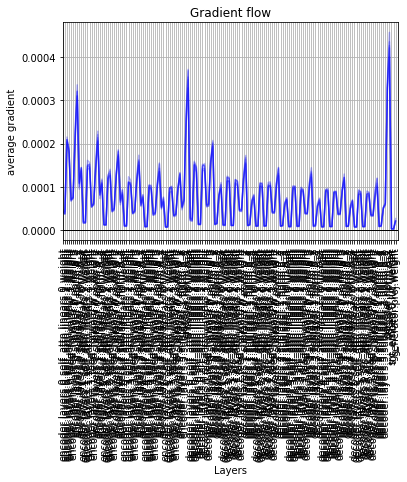

In [210]:
print("Initialising and creating models....")
V=voc.num_words
t1=time.time()
# criterion=LabelSmoothing()
criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)

model=make_model(V,V)
# model.cuda()

# model_opt=torch.optim.Adam(model.parameters(),lr=0.0001,betas=(0.9,0.988),eps=1e-9)
model_opt = NoamOpt(model.src_embed[0].d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))
print("="*100)
print("Creating Models took: "+str(time.time()-t1))

save_dir='C:\\Users\\deepa\\Conversational Agents'
# loadFile=os.path.join(save_dir,'transformer','cornell-movie','2_checkpoint')
# loadFile="C:\\Users\\deepa\\Conversational Agents\\transformer\\cornell-movie\\1_checkpoint.tar"
loadFile=None

if(loadFile):
    checkpoint=torch.load(loadFile)
    model.load_state_dict(checkpoint['model'])
    model_opt.optimizer.load_state_dict(checkpoint['opt'])
    
    

model.train()
training(batches,model,10,5,criterion,model_opt,loadFile)
    

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

In [73]:
model.eval()

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0): Linear(in_features=512, out_features=512, bias=True)
            (1): Linear(in_features=512, out_features=512, bias=True)
            (2): Linear(in_features=512, out_features=512, bias=True)
            (3): Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm()

In [74]:
for batch in batches:
    for i in range(5):
        source=batch.src[i].view(-1,12).to(device)
        source_mask=batch.src_mask[i].view(1,-1,12).to(device)
        output=greedy_decode(model,source,source_mask,10,1)
        src=batch.src[i].view(-1)
        trg=batch.trg[i].view(-1)
        pred=output.view(-1)
        print(src.size())
        for id in src:
            print(id)
        src_sentence=[voc.index2word[id.item()] for id in src]
        trg_sentence=[voc.index2word[id.item()] for id in trg]
        pred_sentence=[voc.index2word[id.item()] for id in pred]
        print(src_sentence)
        print(trg_sentence)
        print(pred_sentence)
        print("-"*80)
#         print("-"*80)
#         print(str(output)+" "+str(batch.src[i])+" "+str(batch.trg[i]))
    

torch.Size([12])
tensor(1)
tensor(997)
tensor(6)
tensor(2)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
['SOS', 'dad', '?', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
['SOS', 'yes', '.', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
['SOS', 'i', 'm', 'a', 'little', 'pounds', '?', 'EOS', '?', 'EOS']
--------------------------------------------------------------------------------
torch.Size([12])
tensor(1)
tensor(3)
tensor(37)
tensor(34)
tensor(5978)
tensor(4)
tensor(2)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
['SOS', 'there', 's', 'no', 'mirror', '.', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
['SOS', 'there', 's', 'not', '.', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
['SOS', 'i', 'm', 'a', 'little', 'hot', '.', 'EOS', '.', 'EOS']
--------------------------------------------------------------------------------
torch.Size([12])
tensor(1)
tensor(4111)
tensor(1075)
tensor(4)
tensor(2)
tensor(0)
tensor(0)
tensor(0)
ten

torch.Size([12])
tensor(1)
tensor(33)
tensor(197)
tensor(117)
tensor(7)
tensor(6)
tensor(2)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
['SOS', 'well', 'don', 't', 'you', '?', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
['SOS', 'you', 're', 'always', 'teasing', '.', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD']
['SOS', 'i', 'm', 'a', 'little', 'pounds', '?', 'EOS', '?', 'EOS']
--------------------------------------------------------------------------------
torch.Size([12])
tensor(1)
tensor(5935)
tensor(4)
tensor(2)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
['SOS', 'luke', '.', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
['SOS', 'hi', 'han', '.', '.', '.', 'chewie', '.', 'EOS', 'PAD', 'PAD']
['SOS', 'i', 'm', 'a', 'little', 'pounds', '?', 'EOS', '?', 'EOS']
--------------------------------------------------------------------------------
torch.Size([12])
tensor(1)
tensor(424)
tensor(76)
tensor(40)
tensor(83)
tensor(4)
tensor(2)
tensor(0)


torch.Size([12])
tensor(1)
tensor(76)
tensor(405)
tensor(2199)
tensor(4)
tensor(2)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
['SOS', 'it', 'says', 'ray', '.', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
['SOS', 'sweet', '.', 'hey', 'you', 'got', 'a', 'tattoo', 'too', '.', 'EOS']
['SOS', 'i', 'm', 'a', 'little', 'hot', '.', 'EOS', '.', 'EOS']
--------------------------------------------------------------------------------
torch.Size([12])
tensor(1)
tensor(34)
tensor(4)
tensor(2)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
tensor(0)
['SOS', 'no', '.', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
['SOS', 'underwear', '?', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
['SOS', 'i', 'm', 'a', 'little', 'pounds', '?', 'EOS', '?', 'EOS']
--------------------------------------------------------------------------------
torch.Size([12])
tensor(1)
tensor(76)
tensor(102)
tensor(177)
tensor(12)
tensor(2559)
tensor(191)
tens

KeyboardInterrupt: 

In [177]:
src = Variable(torch.LongTensor([[1,2,3,4,5,6,7,8,9,10]]) )
src_mask = Variable(torch.ones(1, 1, 10) )
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

tensor([[ 1,  2, 10, 10,  9,  5,  3,  2,  9,  5]])


In [75]:
def evaluate(model,sentence,max_length):
    input_tokens=[indexesFromSentence(voc,sentence)]
    input_tokens=torch.LongTensor(input_tokens)
    input_mask=(input_tokens!=0)
    input_tokens=input_tokens.view(1,-1,12)
    input_mask=input_mask.view(-1,12)
    
    output_tokens=greedy_decode(model,input_tokens,input_mask,max_length,1)
    output_tokens=output_tokens.view(-1)
    decoded_words=[voc.index2word[id.item()] for id in output_tokens]
    return decoded_words

def evaluateInput(model,voc,max_length):
    
    input_sentence=''
    
    while(1):
        try:
            input_sentence=input('<')
            if(input_sentence=='q' or input_sentence=='quit'):
                break
            input_sentence=normalizeString(input_sentence)
            output_words=evaluate(model,input_sentence,max_length)
            output_words=[x for x in output_words if not(x=='EOS' or x=='PAD')]
            print('Bot: ',' '.join(output_words))

        except KeyError:
            print("Unknown Words")

    

In [76]:
evaluateInput(model,voc,10)

<hello there


RuntimeError: Expected object of device type cuda but got device type cpu for argument #3 'index' in call to _th_index_select